In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import scanpy as sc
import cupy as cp

import time
import rapids_singlecell as rsc

In [4]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator

rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=False,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

In [5]:
adata = sc.read("../RData/pbmc_integrated.hd5ad.h5ad")

In [6]:
rsc.get.anndata_to_GPU(adata)

In [7]:
adata

AnnData object with n_obs × n_vars = 10434 × 33694
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nGene', 'nUMI', 'percent.mito', 'Cluster', 'CellType', 'Experiment', 'Method', 'percent.mt', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'predicted.celltype.l3.score', 'predicted.celltype.l3', 'mapping.score', 'unintegrated_clusters', 'scvi_clusters', 'harmony_clusters'
    var: 'names'
    obsm: 'X_harmony', 'X_integrated.scvi', 'X_integrated_dr', 'X_pca', 'X_ref.umap', 'X_umap.harmony', 'X_umap.scvi', 'X_umap.unintegrated'
    layers: 'counts_RNA'

In [14]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator

rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=True,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

In [15]:
%%time
rsc.pp.harmony_integrate(adata, key="Method", dtype=cp.float32)

CPU times: user 1.45 s, sys: 3.21 ms, total: 1.45 s
Wall time: 1.45 s


In [11]:
%%time
rsc.pp.neighbors(adata, n_neighbors=15, n_pcs=40,use_rep="X_pca_harmony",key_added="harmony")
rsc.tl.umap(adata,neighbors_key="harmony",key_added="X_umap_harmony")
rsc.tl.louvain(adata, resolution=0.6,neighbors_key="harmony",key_added="louvain_harmony")
rsc.tl.leiden(adata, resolution=0.6,neighbors_key="harmony",key_added="leiden_harmony")

CPU times: user 937 ms, sys: 700 ms, total: 1.64 s
Wall time: 2.42 s


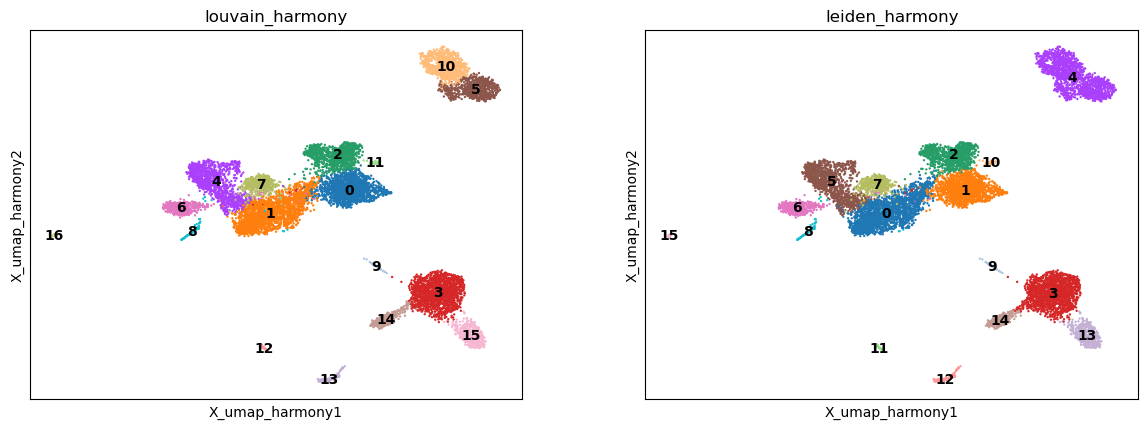

CPU times: user 211 ms, sys: 18.8 ms, total: 230 ms
Wall time: 243 ms


In [12]:
%%time
sc.pl.embedding(adata,basis="X_umap_harmony", color=["louvain_harmony", "leiden_harmony"], legend_loc="on data")

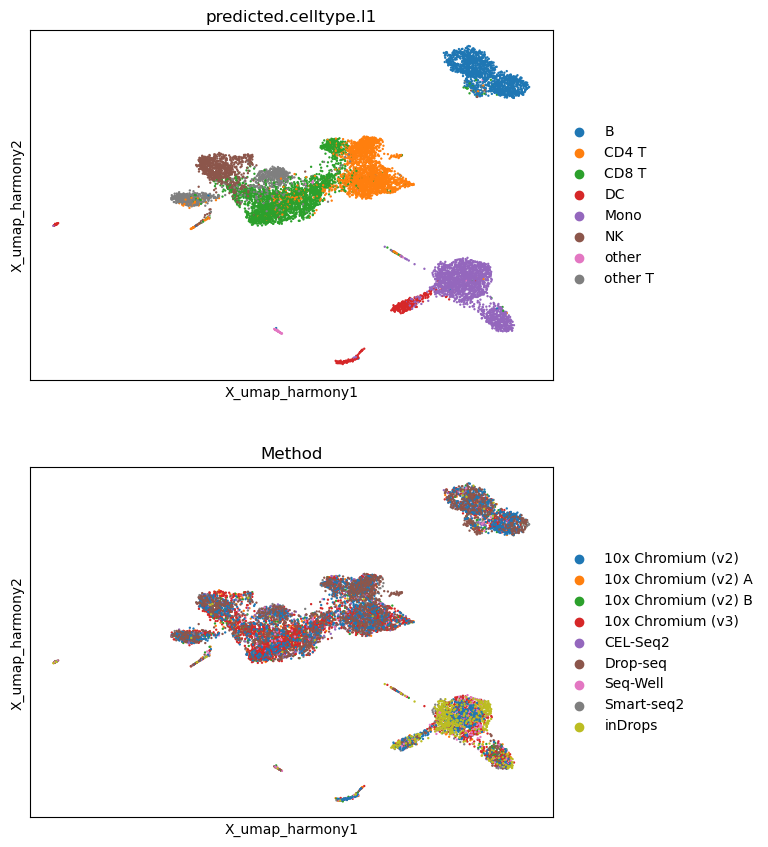

In [13]:
sc.pl.embedding(adata,basis="X_umap_harmony",
                color=["predicted.celltype.l1", "Method"], ncols=1)